In [1]:
import json
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Possible RQs

- Do the human values expressed in a ChangeMyView title effect the stability of a conversation?
    - See if the style (i.e. valence, arousal, dominance and concreteness) change as the comments progress for a post (sort by time)
    - Do conflicts arise (see change in emotion)
    - Not really possible given low comments per post
- Do specific human values induce negativity (per debater or per post)?
    - Sentiment analysis 
    - All seem neutral

In [2]:
PATH = "debaters"

def load_json(path):
    with open(path) as f:
        data = [json.loads(line) for line in tqdm(f.readlines())]
    return data

comments = load_json(os.path.join(PATH, "comments.jsonl"))
debaters_full = load_json(os.path.join(PATH, "debaters-full.jsonl"))
debaters = load_json(os.path.join(PATH, "debaters.jsonl"))

100%|████████████████████████████████████| 3801/3801 [00:00<00:00, 10684.66it/s]


Number of debaters: 3801
Number of posts: 27020
Mean number of comments per post: 9.356291635825315
Mean number of posts per user: 66.51065509076558
Total number of comments among all posts: 252807


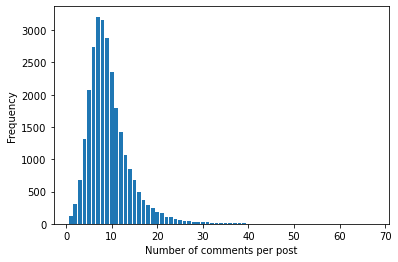

In [3]:
posts = {}
total_comments = 0

for x in comments:
    for c in x["comments"]:
        title = c["op_title"]
        features =  [c["text"], c["created_utc"], 
                     c["style"]["valence"], c["style"]["arousal"], 
                     c["style"]["dominance"], c["style"]["concreteness"]]
        if title not in posts:
            posts[title] = [features]
        else:
            posts[title].append(features)
        total_comments += 1
        
comments_len = [len(x) for x in posts.values()]
posts_len = [len(x["comments"]) for x in debaters]

print("Number of debaters:", len(comments))
print("Number of posts:", len(posts))
print("Mean number of comments per post:", np.mean(comments_len))
print("Mean number of posts per user:", np.mean(posts_len))
print("Total number of comments among all posts:", total_comments)

lens, counts = np.unique(comments_len, return_counts=True)
plt.bar(lens, counts)
plt.xlabel("Number of comments per post")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Get converstation
analyzer = SentimentIntensityAnalyzer()
ex = list(posts.keys())[16]
df = pd.DataFrame(posts[ex], columns=["Post", "Time", "Valence", "Arousal", "Dominance", "Concreteness"])
df = df.sort_values(by=['Time'])

print("Post title:", ex, "\n")
for i in range(df.shape[0]):
    c = df.iloc[i,0]
    print("Comment", i, ":", c)
    print(analyzer.polarity_scores(c))
    print("----")

Post title: CMV: Taylor Swift's recent accidental eight seconds of white noise ("Track 3") proves Death of the Author 

Comment 0 : An isolated case does not prove a broad reality. This case may provie that it is true in the case of Taylor Swift as an author, but it doesn't follow that it carries to all artists.

In some cases "authors" do in fact have much greater control over the presentation of their works and make a point to ensure that the interpretation of their work is not too esoteric.

In general, I largely agree with the world view you present, though. Art is by it's nature in the mind of the observer, not the creator. Art is not important for what the creator wanted, it is important because of what it means when it is observed. Therefore art is inherently multiple. If two people can observe it and have two different interpretations, then those interpretations are both present regardless of authorial intent.

All I'm really arguing is that the case of Taylor Swift's mistaken 

In [15]:
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import expit

    
MODEL = f"cardiffnlp/tweet-topic-21-multi"
tokenizer = AutoTokenizer.from_pretrained(MODEL)


model = AutoModelForSequenceClassification.from_pretrained(MODEL)
class_mapping = model.config.id2label

all_topics = []


for x in tqdm(comments):
    for c in x["comments"]:
        text = c["text"]
        tokens = tokenizer(text, return_tensors='pt')
        output = model(**tokens)
        scores = output[0][0].detach().numpy()
        scores = expit(scores)
#         print(class_mapping)
#         print(np.argmax(scores))
        all_topics.append(np.argmax(scores))
#         k + 1

# text = "It is great to see athletes promoting awareness for climate change."
# tokens = tokenizer(text, return_tensors='pt')
# output = model(**tokens)

scores = output[0][0].detach().numpy()
scores = expit(scores)
predictions = (scores >= 0.5) * 1


# TF
#tf_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
#class_mapping = tf_model.config.id2label
#text = "It is great to see athletes promoting awareness for climate change."
#tokens = tokenizer(text, return_tensors='tf')
#output = tf_model(**tokens)
#scores = output[0][0]
#scores = expit(scores)
#predictions = (scores >= 0.5) * 1

# Map to classes
for i in range(len(predictions)):
  if predictions[i]:
    print(class_mapping[i])

  0%|                                                  | 0/3801 [01:24<?, ?it/s]


KeyboardInterrupt: 